In [29]:
# Import libraries
!pip install statsmodels
!pip install missingno
!pip install scikit-learn
import numpy as np 
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import os
import sklearn
from scipy import stats

In [30]:
df = pd.read_csv('/Users/davidfrost/Documents/modern_data_analytics/assignment/data.csv')

EDA

In [31]:
df.describe()

,temp,humidity,wind,rain,target,events_count,nameday,hour
count,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000,8592.000000
mean,12.801228,74.004323,0.247489,0.000089,54.865553,0.744879,3.007682,11.491504
std,7.170031,18.147165,0.340784,0.000526,6.481056,1.400682,2.002138,6.927257
min,-6.625976,14.875000,0.000000,0.000000,35.825000,0.000000,0.000000,0.000000
25%,7.604880,61.125000,0.017083,0.000000,51.575000,0.000000,1.000000,5.000000
50%,12.604052,78.333333,0.121667,0.000000,56.983333,0.000000,3.000000,11.000000
75%,17.816606,89.166667,0.342500,0.000000,59.433333,1.000000,5.000000,17.000000
max,38.502476,98.750000,3.444167,0.017333,69.066667,16.000000,6.000000,23.000000


In [32]:
# Extracting correct features
from sklearn.model_selection import train_test_split
x = df[['temp', 'nameday', 'hour', 'humidity', 'rain', 'wind', 'events_count']]
  
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

In [33]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.exceptions import NotFittedError

# Define numeric and categorical features
numeric_features = ['temp', 'humidity', 'rain', 'wind', 'events_count']
categorical_features = ['hour', 'nameday']

if 'target' in numeric_features:
    numeric_features.remove('target')

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    sparse_threshold=0
)

# Create pipeline with preprocessor and HistGradientBoostingRegressor
hgr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_leaf_nodes=30))
])

# # Define groups for LeaveOneGroupOut cross-validation
# groups = X_train['hour']  # Assuming 'hour' is used for grouping

# # Fit the pipeline on the training data using LeaveOneGroupOut cross-validation
# for train_index, test_index in LeaveOneGroupOut().split(X_train, y_train, groups):
#     hgr.fit(X_train.iloc[train_index], y_train.iloc[train_index])

hgr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity', 'rain',
                                                   'wind', 'events_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hour', 'nameday'])])),
                ('regressor',
                 HistGradientBoostingRegressor(max_leaf_nodes=30))])

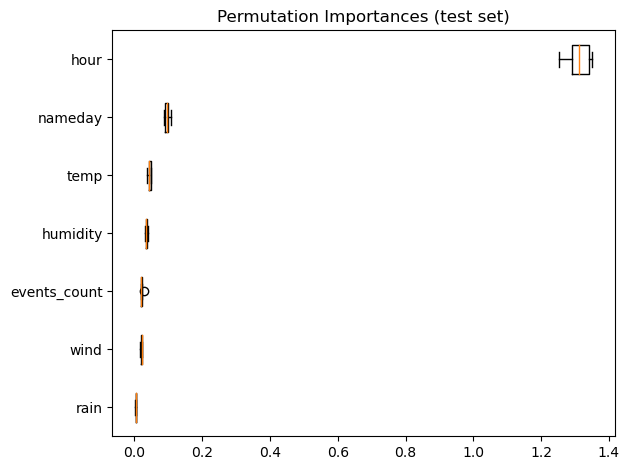

In [13]:
# Make predictions on the test data
hgr_predictions = hgr.predict(X_test)

# Get the permutation importances
try:
    result = permutation_importance(hgr, X_test, y_test, n_repeats=10, random_state=42)
except NotFittedError:
    # Handle the case where the model is not fitted
    result = None

if result is not None:
    sorted_idx = result.importances_mean.argsort()

    # Plot the feature importances
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
else:
    print("Model not fitted.")

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def score_estimator(estimator, X_test, y_test):
    """Score an estimator on the test set."""
    y_pred = np.round(estimator.predict(X_test))

    print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("MAE: %.3f" % mean_absolute_error(y_test, y_pred))
    print("RMSE: %.3f" % np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2: %.3f" % r2_score(y_test, y_pred))

In [35]:
print("HGBR evaluation:")
score_estimator(hgr, X_test, y_test)

HGBR evaluation:
MSE: 10.597
MAE: 2.365
RMSE: 3.255
R2: 0.742


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting

# Define numeric and categorical features
numeric_features = ['temp', 'humidity', 'rain', 'wind', 'events_count']
categoric_features = ['hour', 'nameday']

if 'target' in numeric_features:
    numeric_features.remove('target')

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ],
    sparse_threshold=0
)

model = HistGradientBoostingRegressor()

# Define the hyperparameter grid
hyperparameter_grid = {
    'model__learning_rate': [0.2, 0.3, 0.1],
    'model__max_depth': [100, 200, 300],
    'model__l2_regularization': [0.3, 0.1, 0.01]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

grid_cv = GridSearchCV(estimator=pipeline,
                       param_grid=hyperparameter_grid,
                       scoring='r2',
                       return_train_score=True)

grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(sparse_threshold=0,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['temp',
                                                                          'humidity',
                                                                          'rain',
                                                                          'wind',
                                                                          'events_count']),
                                                                        ('cat',
                                                                       

In [37]:
# Getting the best model
best_model = grid_cv.best_estimator_

# Getting the best parameters
best_params = grid_cv.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Best Hyperparameters:
model__l2_regularization: 0.01
model__learning_rate: 0.2
model__max_depth: 100


In [47]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'humidity', 'rain',
                                                   'wind', 'events_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hour', 'nameday'])])),
                ('model',
                 HistGradientBoostingRegressor(l2_regularization=0.01,
                                               learning_rate=0.2,
                                               max_d

In [38]:
# Make predictions using the best model
best_predictions = best_model.predict(X_test)

In [39]:
print("Best parametrization evaluation:")
score_estimator(best_model, X_test, y_test)

Best parametrization evaluation:
MSE: 10.431
MAE: 2.344
RMSE: 3.230
R2: 0.746


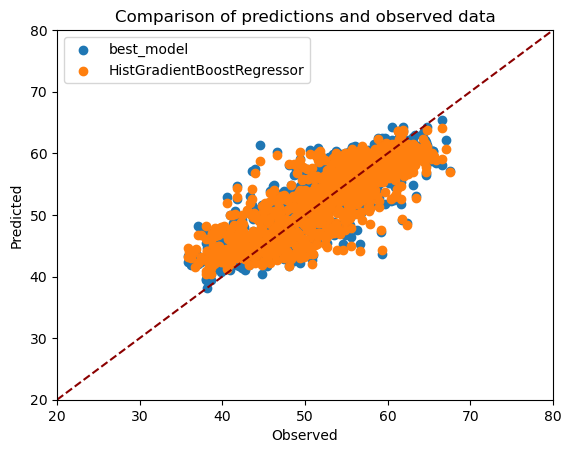

In [40]:
# Plot the comparison of predicted and actual
plt.figure()
plt.title('Comparison of predictions and observed data')
plt.plot([20, 80], [20, 80], color='darkred', linestyle='--')
plt.scatter(y_test, best_predictions, label='best_model')
plt.scatter(y_test, hgr_predictions, label='HistGradientBoostRegressor')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.xlim(20, 80)
plt.ylim(20, 80)
plt.legend()
plt.show()

In [45]:
!pip install beautifulsoup4
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from datetime import timedelta
content = "https://weather.com/weather/hourbyhour/l/c097b546627cdff2da1e276cb9b2731055718a5e7270d777a92857a9701c7870"
response = requests.get(content)
soup = BeautifulSoup(response.content, 'html.parser')

temp_val = soup.findAll('div', attrs={'class':'DetailsTable--field--CPpc_'})


forecast = pd.DataFrame()
forecast['temp'] = [round((int(temp_val[i].text[-3:-1])-32 ) *5/9, 1) for i in list(np.array(range(288))) if i%6 == 0]
forecast['wind'] = [float(temp_val[i].text.split(' ')[1]) for i in list(np.array(range(288))) if i%6 == 1]
forecast['wind_direction'] = [temp_val[i].text.split(' ')[0] for i in list(np.array(range(288))) if i%6 == 1]
forecast['humidity'] = [int(temp_val[i].text[-3:-1]) for i in list(np.array(range(288))) if i%6 == 2]
forecast['cloud_cover'] = [int(temp_val[i].text.replace('Cloud Cover', '')[:-1]) for i in list(np.array(range(288))) if i%6 == 4]
forecast['rain'] = [int(temp_val[i].text.replace('Rain Amount', '').replace(' in', '')) for i in list(np.array(range(288))) if i%6 == 5]
weekday = [(datetime.now()+timedelta(hours=i)).weekday() for i in range(48)]
hour_of_day = [(datetime.now()+timedelta(hours=i)).hour for i in range(48)]
forecast['nameday'] = weekday
forecast['hour'] = hour_of_day
forecast['events_count'] = '4' # This value has to be included by the user. So edit this. The value now is missing, but the model running, so even if nothing is provided, it will run
# This value has to be included by the user. So edit this

In [46]:
# Generate predictions on the test set
prediction_app = best_model.predict(forecast)

In [48]:
import pickle
# Saving the model to a file
filename = '/Users/davidfrost/Documents/modern_data_analytics/assignment/regressor.pkl' # add specific path
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

:)